In [69]:
%pip install -q scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [70]:
"""
COCOParser: A simple parser for the COCO dataset format.

Taken from https://machinelearningspace.com/coco-dataset-a-step-by-step-guide-to-loading-and-visualizing/
Edited to fix some issues and to work with the latest COCO format.
"""

import numpy as np

import json
from collections import defaultdict


class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, "r") as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}

        for ann in coco["annotations"]:
            self.annIm_dict[ann["image_id"]].append(ann)
            self.annId_dict[ann["id"]] = ann

        for img in coco["images"]:
            self.im_dict[img["id"]] = img

        for cat in coco["categories"]:
            self.cat_dict[cat["id"]] = cat

        if "licenses" in coco:
            for license in coco["licenses"]:
                self.licenses_dict[license["id"]] = license
        else:
            # Add a default "No License" entry
            self.licenses_dict[0] = {"id": 0, "name": "No License", "url": ""}
            self.licenses_dict[1] = {"id": 1, "name": "No License", "url": ""}

    def get_imgIds(self):
        return list(self.im_dict.keys())

    def get_imgFileNames(self, im_ids):
        im_ids = im_ids if isinstance(im_ids, list) else [im_ids]
        return [self.im_dict[im_id]["file_name"] for im_id in im_ids]

    def get_annIds(self, im_ids):
        im_ids = im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann["id"] for im_id in im_ids for ann in self.annIm_dict[im_id]]

    def load_anns(self, ann_ids):
        im_ids = ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]

    def load_cats(self, class_ids):
        class_ids = class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]

    def get_imgLicenses(self, im_ids):
        im_ids = im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = []
        for im_id in im_ids:
            img = self.im_dict[im_id]
            if "license" in img:
                lic_ids.append(img["license"])
            else:
                lic_ids.append(1)
        return [self.licenses_dict.get(lic_id, {"id": 1}) for lic_id in lic_ids]

In [71]:
"""
Load the custom dataset
"""

version = "v4"
coco_annotations_file = (
    f"./datasets/FriendsCOCO{version}/annotations/instances_val2017.json"
)
coco_images_dir = f"./datasets/FriendsCOCO{version}/val2017/"
coco = COCOParser(coco_annotations_file, coco_images_dir)

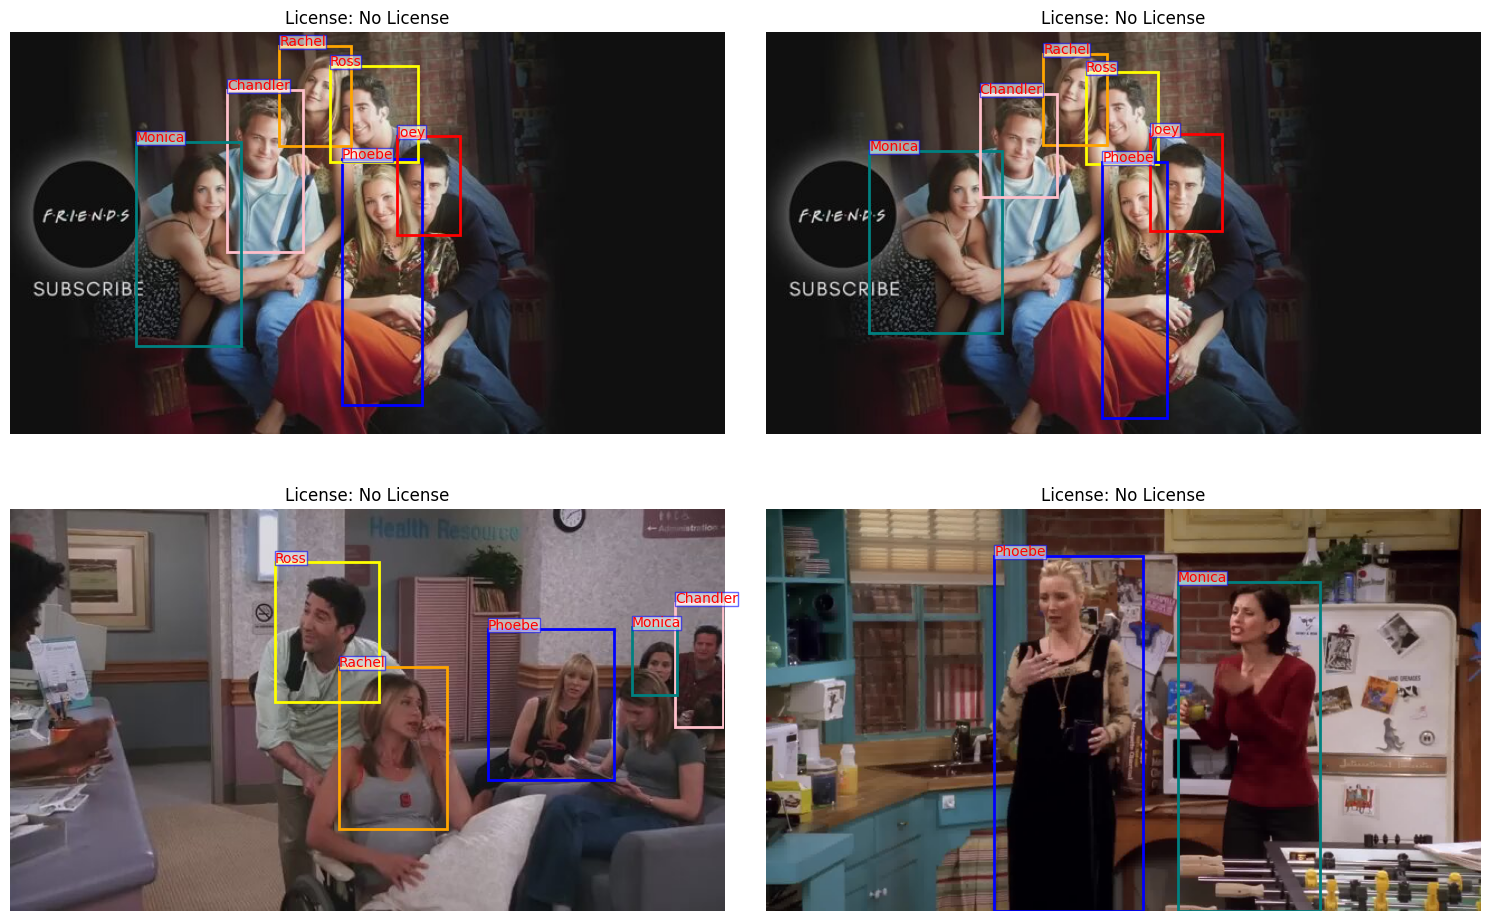

In [72]:
"""
Visualize a few images with bounding boxes
"""

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# define a list of colors for drawing bounding boxes
color_list = [
    "pink",
    "red",
    "teal",
    "blue",
    "orange",
    "yellow",
    "black",
    "magenta",
    "green",
    "aqua",
] * 10

# number of images to display
num_imgs_to_disp = 4

# total number of images in the dataset
total_images = len(coco.get_imgIds())

# randomly select images to display
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]

# get all image IDs in the dataset
img_ids = coco.get_imgIds()

# get the selected image IDs and their annotations
selected_img_ids = [img_ids[i] for i in sel_im_idxs]

# get the annotations for the selected images
ann_ids = coco.get_annIds(selected_img_ids)

# load the annotations for the selected images
im_licenses = coco.get_imgLicenses(selected_img_ids)

# create a figure with subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax = ax.ravel()

# loop through the selected images and plot them with bounding boxes
for i, im in enumerate(selected_img_ids):

    image = Image.open(f"{coco_images_dir}/{coco.get_imgFileNames(im)[0]}")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)

    for ann in annotations:
        bbox = ann["bbox"]
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor=color_, facecolor="none"
        )
        t_box = ax[i].text(x, y, class_name, color="red", fontsize=10)
        t_box.set_bbox(
            dict(
                boxstyle="square, pad=0", facecolor="white", alpha=0.6, edgecolor="blue"
            )
        )
        ax[i].add_patch(rect)

    ax[i].axis("off")
    ax[i].imshow(image)
    ax[i].set_xlabel("Longitude")
    ax[i].set_title(f"License: {license}")

plt.tight_layout()
plt.show()

In [73]:
"""
Use YOLOX to run inference on the COCO dataset.
Use Sklearn Metrics to calculate precision, recall, F1 score, and accuracy.
"""

import torch

from yolox.data.datasets import FRIENDS_CLASSES

from tools.demo import Predictor, get_exp

# Load Model
exp = get_exp(f"./exps/example/custom/friends{version}.py", "friends{version}")
ckpt = torch.load(
    f"./YOLOX_outputs/friends{version}/best_ckpt.pth",
    map_location="cpu",
    weights_only=False,
)
model = exp.get_model()
model.eval()
model.load_state_dict(ckpt["model"])

# Create Predictor
predictor = Predictor(
    model=model,
    exp=exp,
    cls_names=FRIENDS_CLASSES,
    trt_file=None,
    decoder=None,
    device="cpu",
    fp16=False,
    legacy=False,
)

# Initialize lists to store true and predicted classes
y_true = []
y_pred = []

# Loop through the dataset run inference
for i, im in enumerate(img_ids):

    # Load annotations and class ids
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    class_ids = [ann["category_id"] for ann in annotations]

    # Set the expected classes
    y_true_i = class_ids

    # Run Inference
    outputs, img_info = predictor.inference(
        f"{coco_images_dir}/{coco.get_imgFileNames(im)[0]}"
    )

    # Process Output
    output = outputs[0].cpu()
    classes = output[:, 6]
    scores = output[:, 4] * output[:, 5]

    # Define a confidence threshold
    CONFIDENCE = 0.75

    # Initialized predicted classes list
    y_pred_i = []

    # Capture the predicted classes
    for i in range(len(classes)):
        _class = int(classes[i])
        _score = scores[i]

        # Filter out predictions below the confidence threshold
        if _score < CONFIDENCE:
            continue

        # Print the predicted class name and score
        _class_name = predictor.cls_names[_class]
        _class_score = _score * 100
        text = "{}: {:.1f}%".format(_class_name, _class_score)
        print(text)

        # Save the predicted class name
        y_pred_i.append(_class)

    # Validation frames has 1 or more annotations
    # Prediction frames may have 0 or more predictions
    # We have ensure the results are comparable
    # So we are going to truncate or pad the y_pred list
    if len(y_pred_i) < len(y_true_i):
        # Pad with zeros
        y_pred_i += [-1] * (len(y_true_i) - len(y_pred_i))
    elif len(y_pred_i) > len(y_true_i):
        # Truncate to match length
        y_pred_i = y_pred_i[: len(y_true_i)]

    # Sort the lists to ensure they are comparable
    y_true_i.sort()
    y_pred_i.sort()

    # Append the true and predicted classes to the lists
    y_true.extend(y_true_i)
    y_pred.extend(y_pred_i)

# To make a trivial test, we can use the prediction as the true class
# Uncomment the next line to use the predicted classes as true classes
# The result should be 100% accuracy
# y_true = y_pred.copy()

2025-05-31 13:40:18.467 | INFO     | tools.demo:inference:165 - Infer time: 0.0767s


2025-05-31 13:40:18.552 | INFO     | tools.demo:inference:165 - Infer time: 0.0782s
2025-05-31 13:40:18.635 | INFO     | tools.demo:inference:165 - Infer time: 0.0763s
2025-05-31 13:40:18.719 | INFO     | tools.demo:inference:165 - Infer time: 0.0765s


Ross: 83.9%


2025-05-31 13:40:18.802 | INFO     | tools.demo:inference:165 - Infer time: 0.0765s
2025-05-31 13:40:18.888 | INFO     | tools.demo:inference:165 - Infer time: 0.0789s
2025-05-31 13:40:18.986 | INFO     | tools.demo:inference:165 - Infer time: 0.0890s
2025-05-31 13:40:19.098 | INFO     | tools.demo:inference:165 - Infer time: 0.1033s
2025-05-31 13:40:19.202 | INFO     | tools.demo:inference:165 - Infer time: 0.0955s
2025-05-31 13:40:19.302 | INFO     | tools.demo:inference:165 - Infer time: 0.0907s
2025-05-31 13:40:19.393 | INFO     | tools.demo:inference:165 - Infer time: 0.0836s
2025-05-31 13:40:19.483 | INFO     | tools.demo:inference:165 - Infer time: 0.0843s


Rachel: 83.7%
Joey: 89.7%
Monica: 79.2%


2025-05-31 13:40:19.566 | INFO     | tools.demo:inference:165 - Infer time: 0.0777s
2025-05-31 13:40:19.649 | INFO     | tools.demo:inference:165 - Infer time: 0.0770s
2025-05-31 13:40:19.732 | INFO     | tools.demo:inference:165 - Infer time: 0.0778s


Joey: 91.4%
Phoebe: 89.4%
Monica: 84.8%
Phoebe: 89.8%
Monica: 84.4%
Phoebe: 90.7%
Monica: 84.1%


2025-05-31 13:40:19.815 | INFO     | tools.demo:inference:165 - Infer time: 0.0778s
2025-05-31 13:40:19.897 | INFO     | tools.demo:inference:165 - Infer time: 0.0767s
2025-05-31 13:40:19.979 | INFO     | tools.demo:inference:165 - Infer time: 0.0777s


Phoebe: 88.2%
Monica: 83.1%
Phoebe: 90.4%
Monica: 79.9%
Phoebe: 89.4%
Monica: 86.3%


2025-05-31 13:40:20.075 | INFO     | tools.demo:inference:165 - Infer time: 0.0905s
2025-05-31 13:40:20.157 | INFO     | tools.demo:inference:165 - Infer time: 0.0766s
2025-05-31 13:40:20.238 | INFO     | tools.demo:inference:165 - Infer time: 0.0771s


Phoebe: 89.2%
Monica: 87.6%
Phoebe: 90.0%
Monica: 88.5%
Joey: 84.8%


2025-05-31 13:40:20.320 | INFO     | tools.demo:inference:165 - Infer time: 0.0773s
2025-05-31 13:40:20.398 | INFO     | tools.demo:inference:165 - Infer time: 0.0748s
2025-05-31 13:40:20.474 | INFO     | tools.demo:inference:165 - Infer time: 0.0743s


Joey: 88.7%
Rachel: 90.8%
Ross: 89.7%
Rachel: 83.8%
Ross: 79.2%
Rachel: 75.7%


2025-05-31 13:40:20.551 | INFO     | tools.demo:inference:165 - Infer time: 0.0743s
2025-05-31 13:40:20.627 | INFO     | tools.demo:inference:165 - Infer time: 0.0738s
2025-05-31 13:40:20.704 | INFO     | tools.demo:inference:165 - Infer time: 0.0740s


Rachel: 88.8%
Rachel: 80.6%
Ross: 78.7%
Chandler: 77.0%


              precision    recall  f1-score   support

    Chandler       0.00      0.00      0.00         9
        Joey       0.75      0.38      0.50         8
      Monica       0.89      0.62      0.73        13
      Phoebe       1.00      0.44      0.62        18
      Rachel       0.50      0.50      0.50         6
        Ross       0.75      0.60      0.67         5

   micro avg       0.78      0.42      0.55        59
   macro avg       0.65      0.42      0.50        59
weighted avg       0.72      0.42      0.52        59



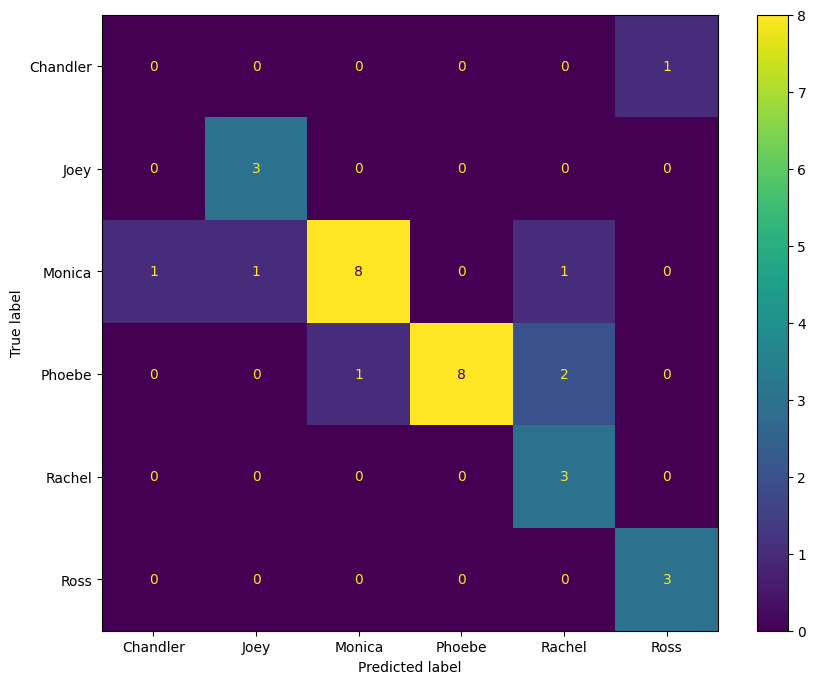

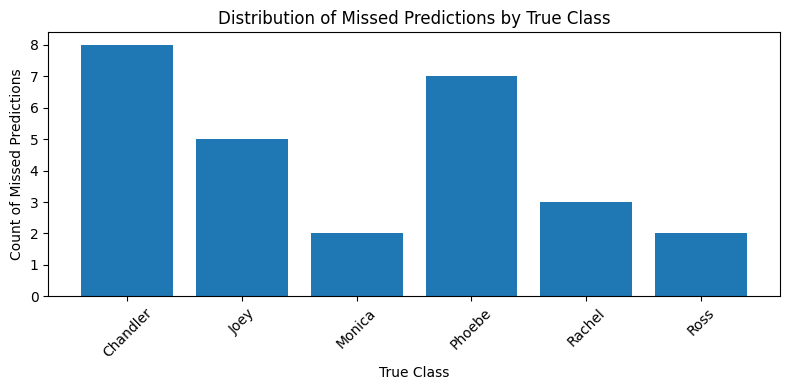

In [79]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

# Compute Quantitative Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="micro")
f1 = f1_score(y_true, y_pred, average="micro")
recall = recall_score(y_true, y_pred, average="micro")
quantitative_report = classification_report(
    y_true,
    y_pred,
    labels=[0, 1, 2, 3, 4, 5],
    target_names=FRIENDS_CLASSES,
    zero_division=0,
)
print(quantitative_report)

# Calculate Qualitative Metrics
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])

labels_with_missed = ("Missed",) + tuple(FRIENDS_CLASSES)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=FRIENDS_CLASSES,
)
disp.plot(ax=ax)
plt.show()

# Plot the misclassifications where y_pred is -1

misclassified_indices = [i for i, pred in enumerate(y_pred) if pred == -1]
misclassified_true_labels = [y_true[i] for i in misclassified_indices]

plt.figure(figsize=(8, 4))
plt.hist(misclassified_true_labels, bins=np.arange(7)-0.5, rwidth=0.8, align='mid')
plt.xticks(range(len(FRIENDS_CLASSES)), FRIENDS_CLASSES, rotation=45)
plt.xlabel("True Class")
plt.ylabel("Count of Missed Predictions")
plt.title("Distribution of Missed Predictions by True Class")
plt.tight_layout()
plt.show()

2025-05-31 13:42:51.293 | INFO     | tools.demo:inference:165 - Infer time: 0.0735s
2025-05-31 13:42:51.372 | INFO     | tools.demo:inference:165 - Infer time: 0.0725s
2025-05-31 13:42:51.449 | INFO     | tools.demo:inference:165 - Infer time: 0.0724s
2025-05-31 13:42:51.537 | INFO     | tools.demo:inference:165 - Infer time: 0.0744s


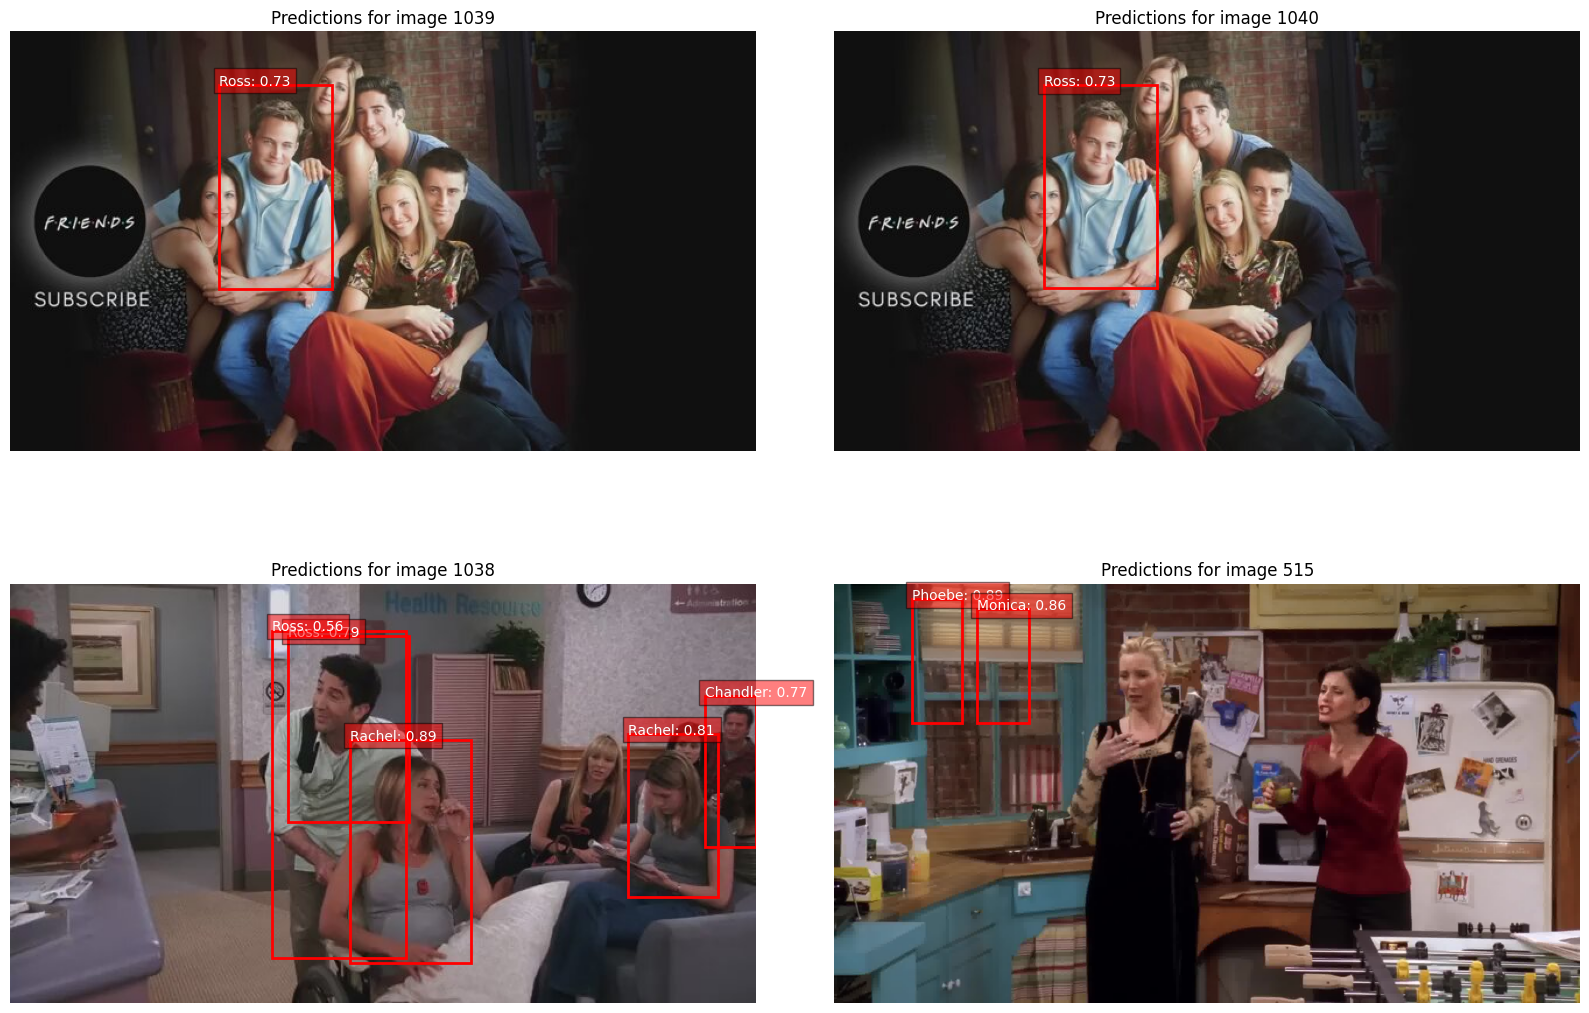

In [78]:
"""
Visualize predictions for a sample image using YOLOX outputs.
"""

import matplotlib.pyplot as plt

# Visualize predictions for the 4 selected images
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, img_id in enumerate(selected_img_ids):
    img_path = f"{coco_images_dir}/{coco.get_imgFileNames(img_id)[0]}"
    image = Image.open(img_path).convert("RGB")
    outputs, img_info = predictor.inference(img_path)
    output = outputs[0].cpu()

    axes[idx].imshow(image)
    ax = axes[idx]

    for det in output:
        x0, y0, x1, y1, obj_conf, cls_conf, cls_id = det.tolist()
        score = obj_conf * cls_conf
        if score < 0.5:
            continue
        cls_id = int(cls_id)
        color = "red"
        rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        label = f"{predictor.cls_names[cls_id]}: {score:.2f}"
        ax.text(x0, y0, label, color="white", fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

    ax.axis("off")
    ax.set_title(f"Predictions for image {img_id}")

plt.tight_layout()
plt.show()